In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
!pip install konlpy
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split #문제발생
from collections import Counter
from konlpy.tag import Mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [80]:

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
total_game_data = pd.read_table('steam.txt', names=['label', 'document'])

train_game_data2, test_game_data2 = train_test_split(total_game_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))
print('훈련용 리뷰의 개수 :', len(train_game_data2))
print('테스트용 리뷰의 개수 :', len(test_game_data2))




훈련용 리뷰의 개수 : 150000
테스트용 리뷰의 개수 : 50000
훈련용 리뷰의 개수 : 75000
테스트용 리뷰의 개수 : 25000


In [81]:
train_data = pd.concat([train_data, train_game_data2])
test_data = pd.concat([test_data, test_game_data2])


train_data = train_data.sample(frac=1).reset_index(drop=True).drop(['id'],axis=1)
test_data = test_data.sample(frac=1).reset_index(drop=True).drop(['id'],axis=1)


print(train_data.head())
print()
print(train_data.tail())
print()
print(test_data.head())
print(test_data.tail())

                                            document  label
0                                         진짜명작인생영화다.      1
1                                   나도 이제 영화감독이다!!!!      0
2      유딩때 엄마가 사다준 번개용이라는 비디오를 봤었는데... 꾀 잼있던걸로 기억...      1
3                          안 보는게 좋은 영화. 그나마 음악은 괜찮다.      0
4  분명 중국 게임도 좋은 게임이 있을 수 있습니다만 여기에는 오리지날이 느껴지지 않습...      1

                                                 document  label
224995                       매 순간이 소중함을 노래가사로 느낄 수 있는 영화!      1
224996  볼게없어서 보기는하다만...참....가면갈수록 화딱지나는드라마..화영엄마보면 참.....      0
224997                                            여전히 재밌다      1
224998                                 내이거 글남겻는데 지웟나?도랏나?      0
224999                              익숙한 설정 영화자체도 큰 매력이 없다      0

                                            document  label
0                                   피터팬 , 팅커벨과 후크 선장      1
1                  보는 내내 몰입이 하나도 안된다. 81분간 바보가 된 느낌?      0
2  UI가 별로임 화면이 사선으로 고정되서 맵을 훑어보기에도 불편하고 바닥에 격자라도 ...      0
3       

In [82]:

#중복제거 -> 약 4000개 중복됨
print('전처리 전 샘플의 수 :',len(train_data))
print(train_data['document'].nunique(), train_data['label'].nunique())
train_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train_data = train_data.dropna(how='any') # Null 값 제거
print(train_data.isnull().sum())
print('전처리 후 수 :',len(train_data))



전처리 전 샘플의 수 : 225000
220916 2
document    0
label       0
dtype: int64
전처리 후 수 : 220127


In [83]:
print('전처리 전 테스트용 샘플의 개수 :',len(test_data))
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 전 테스트용 샘플의 개수 : 75000
전처리 후 테스트용 샘플의 개수 : 73816


In [84]:

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)



100%|██████████| 73816/73816 [06:19<00:00, 194.39it/s]


In [85]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print('전처리 후 훈련용 샘플의 개수 :',len(X_train))
print('전처리 후 테스트용 샘플의 개수 :',len(X_test))

print(tokenizer.word_index)
print(tokenizer.word_counts.items())

print(X_train[:3])


전처리 후 훈련용 샘플의 개수 : 220127
전처리 후 테스트용 샘플의 개수 : 73816
{'영화': 1, '보다': 2, '을': 3, '게임': 4, '없다': 5, '있다': 6, '이다': 7, '좋다': 8, '되다': 9, '너무': 10, '같다': 11, '다': 12, '재밌다': 13, '로': 14, '만': 15, '적': 16, '않다': 17, '아니다': 18, '정말': 19, '안': 20, '진짜': 21, '에서': 22, '것': 23, '못': 24, '만들다': 25, '나오다': 26, '나': 27, '내': 28, '점': 29, '인': 30, '스토리': 31, '생각': 32, '시간': 33, '사람': 34, '그': 35, '때': 36, '고': 37, '왜': 38, '게': 39, '더': 40, '거': 41, '재미있다': 42, '재미': 43, '그냥': 44, '아': 45, '최고': 46, '하고': 47, '수': 48, '연기': 49, '평점': 50, '모르다': 51, '말': 52, '요': 53, '안되다': 54, '겜': 55, '이렇다': 56, '뭐': 57, '보고': 58, '자다': 59, '중': 60, '가다': 61, '개': 62, '주다': 63, '까지': 64, '아깝다': 65, '많다': 66, '그렇다': 67, '들다': 68, '드라마': 69, '감동': 70, 'ㅋㅋ': 71, '싶다': 72, '정도': 73, '알다': 74, '플레이': 75, '추천': 76, '네': 77, '하나': 78, '지': 79, '재미없다': 80, '돈': 81, '지루하다': 82, '쓰레기': 83, '배우': 84, '하': 85, '처음': 86, '다시': 87, '해보다': 88, '내용': 89, '감독': 90, '저': 91, '오다': 92, '사다': 93, '인데': 94, '걸': 95, '느낌': 96, '면': 97, 

In [86]:

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 56543
등장 빈도가 2번 이하인 희귀 단어의 수: 31795
단어 집합에서 희귀 단어의 비율: 56.231540597421436
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4762511157756202


In [87]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)


단어 집합의 크기 : 24749


In [88]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])


In [90]:
print(len(X_train))
print(len(y_train))

print(X_train[:3])


220127
220127
[[21, 146, 209, 1, 12], [104, 307, 3057, 7], [20861, 636, 93, 616, 8364, 1408, 208, 916, 2, 6167, 233, 14, 225]]


In [91]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))


219652
219652
73636
73636


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 11.778677180266968


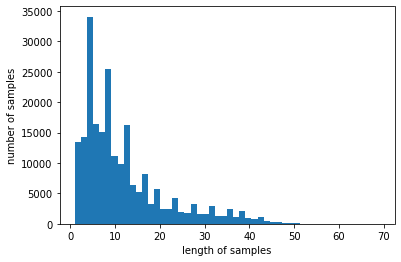

In [92]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [93]:

def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 35 ###변경
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 35 이하인 샘플의 비율: 96.07834210478393


In [94]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)


In [95]:

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(128))
model.add(Dense(64))
model.add(Dropout(0.15))
model.add(Dense(32))
model.add(Dropout(0.1))
model.add(Dense(16))
model.add(Dense(1, activation='sigmoid'))





In [96]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=12, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/12
2746/2746 [==============================] - 284s 102ms/step - loss: 0.4264 - acc: 0.8024 - val_loss: 0.4013 - val_acc: 0.8198

Epoch 00001: val_acc improved from -inf to 0.81976, saving model to best_model.h5
Epoch 2/12
2746/2746 [==============================] - 278s 101ms/step - loss: 0.3398 - acc: 0.8509 - val_loss: 0.3998 - val_acc: 0.8265

Epoch 00002: val_acc improved from 0.81976 to 0.82655, saving model to best_model.h5
Epoch 3/12
2746/2746 [==============================] - 278s 101ms/step - loss: 0.2876 - acc: 0.8764 - val_loss: 0.4398 - val_acc: 0.8219

Epoch 00003: val_acc did not improve from 0.82655
Epoch 4/12
2746/2746 [==============================] - 279s 102ms/step - loss: 0.2395 - acc: 0.8992 - val_loss: 0.4655 - val_acc: 0.8171

Epoch 00004: val_acc did not improve from 0.82655
Epoch 5/12
2746/2746 [==============================] - 280s 102ms/step - loss: 0.1960 - acc: 0.9191 - val_loss: 0.5525 - val_acc: 0.8133

Epoch 00005: val_acc did not improve f

In [97]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
print(X_test[1])
print()
print(y_test[1])
print()
print(loaded_model.predict(X_test[1],y_test[1]))

2302/2302 [==============================] - 28s 12ms/step - loss: 0.3971 - acc: 0.8275

 테스트 정확도: 0.8275
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    2  414
  341   78   54 5173 1228    9   96]

0

[[0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.5106374 ]
 [0.58918613]
 [0.37489057]
 [0.82687104]
 [0.35656017]
 [0.13774422]
 [0.36775798]
 [0.19597131]
 [0.70099413]
 [0.3981961 ]]


In [98]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [99]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

97.73% 확률로 긍정 리뷰입니다.



In [100]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

93.93% 확률로 부정 리뷰입니다.



In [101]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

99.20% 확률로 부정 리뷰입니다.



In [102]:
sentiment_predict('감독 뭐하는 놈이냐?')

95.01% 확률로 부정 리뷰입니다.



In [103]:
sentiment_predict('?')

53.71% 확률로 부정 리뷰입니다.



In [104]:
sentiment_predict('어 좋아요. 재난지원금 주세요! 받고 이재명안뽑기')

70.02% 확률로 부정 리뷰입니다.



In [107]:
sentiment_predict('정부의 정책오류와 이상한 오기로 주택가격은 폭등하고 법은누더기됨. 이제와 대출까지막아 사다리끊는 정부를 지지하는 40%는 진짜 실체가있는걸까.. 이제는이재명이 뿌리는 30,40 만원에 넘어갈 국민이 아니라 믿고싶으다..ㅠㅡㅠ')

60.28% 확률로 부정 리뷰입니다.

